In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tpu-getting-started/sample_submission.csv
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/09-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/14-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/01-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/13-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/00-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/07-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/12-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/11-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/05-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/04-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/15-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecord

In [2]:
import tensorflow as tf
from kaggle_datasets import KaggleDatasets
import math, os, re, warnings
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


In [4]:
GCS_DS_PATH = KaggleDatasets().get_gcs_path()

In [5]:
IMAGE_SIZE = [224, 224] # at this size, a GPU will run out of memory. Use the TPU
EPOCHS = 50
#BATCH_SIZE = 16 * strategy.num_replicas_in_sync
BATCH_SIZE = 16
AUTO = tf.data.experimental.AUTOTUNE
NUM_TRAINING_IMAGES = 12753
NUM_TEST_IMAGES = 7382
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
TRAIN_FILENAMES = tf.io.gfile.glob(GCS_DS_PATH + '/tfrecords-jpeg-224x224/train/*.tfrec')
VAL_FILENAMES = tf.io.gfile.glob(GCS_DS_PATH + '/tfrecords-jpeg-224x224/val/*.tfrec')                                   
TEST_FILENAMES = tf.io.gfile.glob(GCS_DS_PATH + '/tfrecords-jpeg-224x224/test/*.tfrec')
print(STEPS_PER_EPOCH)

797


In [6]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of image(s)

def data_augment(image, label):
    # data augmentation. Thanks to the dataset.prefetch(AUTO) statement in the next function (below),
    # this happens essentially for free on TPU. Data pipeline code is executed on the "CPU" part
    # of the TPU while the TPU itself is computing gradients.
    image = tf.image.random_flip_left_right(image)
    image = random_blockout(image)
    image = transform(image)
    return image, label   

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

def get_training_dataset():
    dataset = load_dataset(TRAIN_FILENAMES, labeled=True)
    #dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

def get_validation_dataset():
    dataset = load_dataset(VAL_FILENAMES, labeled=True, ordered=False)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)


In [7]:
NUM_TRAINING_IMAGES = count_data_items(TRAIN_FILENAMES)
training_dataset = get_training_dataset()
y_train = next(iter(training_dataset.unbatch().map(lambda image, label: label).batch(NUM_TRAINING_IMAGES))).numpy()
print('Number of training images %d' % NUM_TRAINING_IMAGES)

Number of training images 12753


In [8]:
NUM_VALIDATION_IMAGES = count_data_items(VAL_FILENAMES)
validation_dataset = get_validation_dataset()
y_valid = next(iter(validation_dataset.unbatch().map(lambda image, label: label).batch(NUM_VALIDATION_IMAGES))).numpy()
print('Number of training images %d' % NUM_VALIDATION_IMAGES)

Number of training images 3712


In [9]:
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
print('Number of test images %d' % NUM_TEST_IMAGES)
test_dataset = get_test_dataset(ordered=True)

Number of test images 7382


In [10]:
with strategy.scope():    
    pretrained_model = tf.keras.applications.VGG19(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])
    pretrained_model.trainable = False # tramsfer learning
    
    model = tf.keras.Sequential([
        pretrained_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(104, activation='softmax')
    ])
        
model.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

historical = model.fit(training_dataset, 
          steps_per_epoch=STEPS_PER_EPOCH, 
          epochs=EPOCHS, 
          validation_data=validation_dataset)

80142336/80134624 [==============================] - 1s 0us/step
Epoch 1/50
797/797 [==============================] - 35s 33ms/step - loss: 3.9616 - sparse_categorical_accuracy: 0.1399 - val_loss: 3.1731 - val_sparse_categorical_accuracy: 0.2724
Epoch 2/50
797/797 [==============================] - 19s 24ms/step - loss: 3.0338 - sparse_categorical_accuracy: 0.2965 - val_loss: 2.7357 - val_sparse_categorical_accuracy: 0.3618
Epoch 3/50
797/797 [==============================] - 19s 24ms/step - loss: 2.6371 - sparse_categorical_accuracy: 0.3965 - val_loss: 2.4535 - val_sparse_categorical_accuracy: 0.4480
Epoch 4/50
797/797 [==============================] - 19s 24ms/step - loss: 2.3503 - sparse_categorical_accuracy: 0.4572 - val_loss: 2.2637 - val_sparse_categorical_accuracy: 0.4841
Epoch 5/50
797/797 [==============================] - 20s 25ms/step - loss: 2.1608 - sparse_categorical_accuracy: 0.4967 - val_loss: 2.1315 - val_sparse_categorical_accuracy: 0.5092
Epoch 6/50
797/797 [=====

In [11]:
from matplotlib import pyplot as plt
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

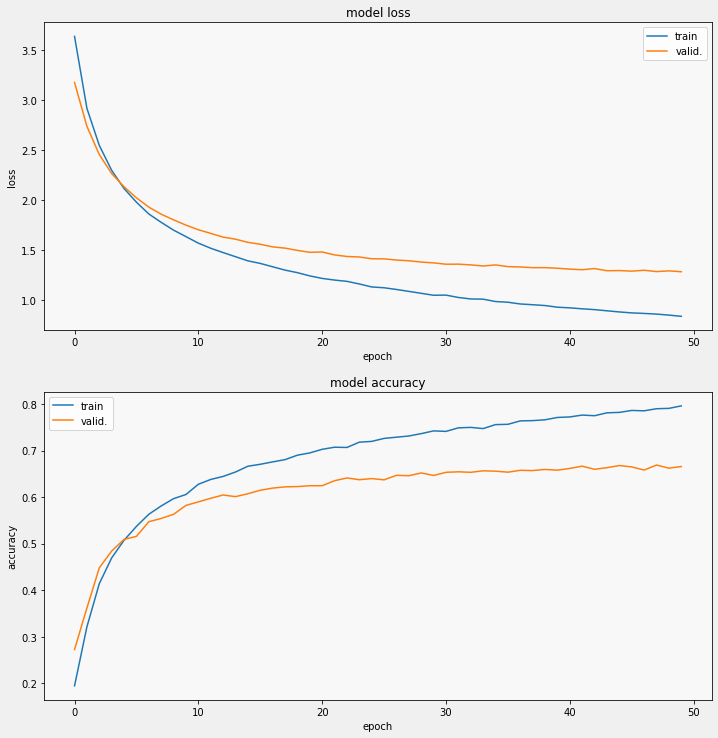

In [12]:
display_training_curves(
    historical.history['loss'],
    historical.history['val_loss'],
    'loss',
    211,
)
display_training_curves(
    historical.history['sparse_categorical_accuracy'],
    historical.history['val_sparse_categorical_accuracy'],
    'accuracy',
    212,
)

In [13]:
test_ds = get_test_dataset(ordered=True) # since we are splitting the dataset and iterating separately on images and ids, order matters.

print('Computing predictions...')
test_images_ds = test_ds.map(lambda image, idnum: image)
probabilities = model.predict(test_images_ds)
predictions = np.argmax(probabilities, axis=-1)

test_ids_ds = test_ds.map(lambda image, idnum:idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U')

submission = pd.DataFrame(test_ids, columns=['id'])
submission['label'] = predictions

print(submission)

# Write the submission file
np.savetxt(
    'submission.csv',
    np.rec.fromarrays([test_ids, predictions]),
    fmt=['%s', '%d'],
    delimiter=',',
    header='id,label',
    comments='',
)

Computing predictions...
             id  label
0     252d840db     67
1     1c4736dea     28
2     c37a6f3e9     81
3     00e4f514e    103
4     59d1b6146     46
...         ...    ...
7377  c785abe6f      7
7378  9b9c0e574     50
7379  e46998f4d     49
7380  523df966b    102
7381  e86e2a592     62

[7382 rows x 2 columns]
